Tutorial of SpatialGPT
---
**Train on one slice, just make sure the pipeline is correct.**

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**System parameters setting**

In [2]:
from SpatialGPT.config import config
opt = config()
args = opt.parse_args(['--gpu', '0'])
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
args.max_epoch = 30
if args.version.split('-')[0] != 'dev':
    warnings.filterwarnings("ignore")
args

Namespace(amp=True, batch_size=32, clusters=0, d_model=100, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder='NB', dropout=0.2, f_dim=512, fast=True, flow='source_to_target', gid_emb=45, gpu=0, hvgs=1200, latent_dim=64, log_file='../Log', log_steps=1, lr=0.0001, max_epoch=30, max_neighbors=6, n_gcn=5, n_head=4, n_layer=4, n_randomwalk=[5, 15], n_randwalk=50, n_spot=0, n_token=60697, out_file='../Output', p_randomwalk=[1, 1.5], project_name='SpatialGPT', q_randomwalk=[1, 0.5], schedule_ratio=0.9, seed=2024, srt_resolution=150, tau=1, version='dev-1.0', visual=True, vocab_path='/home/zl/SpatialGRN/Data/default_census_vocab.json', wegiht_decay=0)

**Set global seed**

In [3]:
from SpatialGPT.utils import set_random_seed
set_random_seed(args.seed)

**Reading dataset**

In [4]:
sector = '151507'
adata = sc.read_visium(os.path.join(args.dataset_path+sector))
adata

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

SpatialGRN initialization

In [6]:
from torchtext.vocab import Vocab
import torchtext.vocab as torch_vocab
from typing_extensions import Self

In [14]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [ ]:
from SpatialGPT.spatialgpt import SpatailGPT
sg = SpatailGPT(args, adata)

using device cuda:0
Average spatial edge: 7.8708133971291865


Tokenization of genes

In [ ]:
from SpatialGPT.tokenizer import GeneRep
embedding = GeneRep(sg.args)(sg.x, sg.edge_index)
embedding.size()

torch.Size([9196, 3000, 10])

In [ ]:
import torch
torch.save(embedding, os.path.join(sg.args.output_dir, os.path.basename(sg.args.dataset_path)+'_embedding.pt'))

Training Transformer-based model

In [ ]:
sg.fit(embedding)

Getting the spot-specific gene interaction matrix

In [ ]:
from SpatialGPT.utils import find_neighbors
find_neighbors(1, sg.edge_index)

tensor([   2,   84,   85, 9115])

In [ ]:
# path = sg.eval(embedding)[0]
# loaded_att = []
# with open(path, 'rb') as f:
#     while True:
#         try:
#             loaded_att.append(np.load(f))
#         except EOFError:
#             break
# loaded_att = np.concatenate(loaded_att, axis=0)

Visiualiztion of GRN

In [ ]:
# attn_weights = sgrn
# attn_weights.size()

NameError: name 'sgrn' is not defined

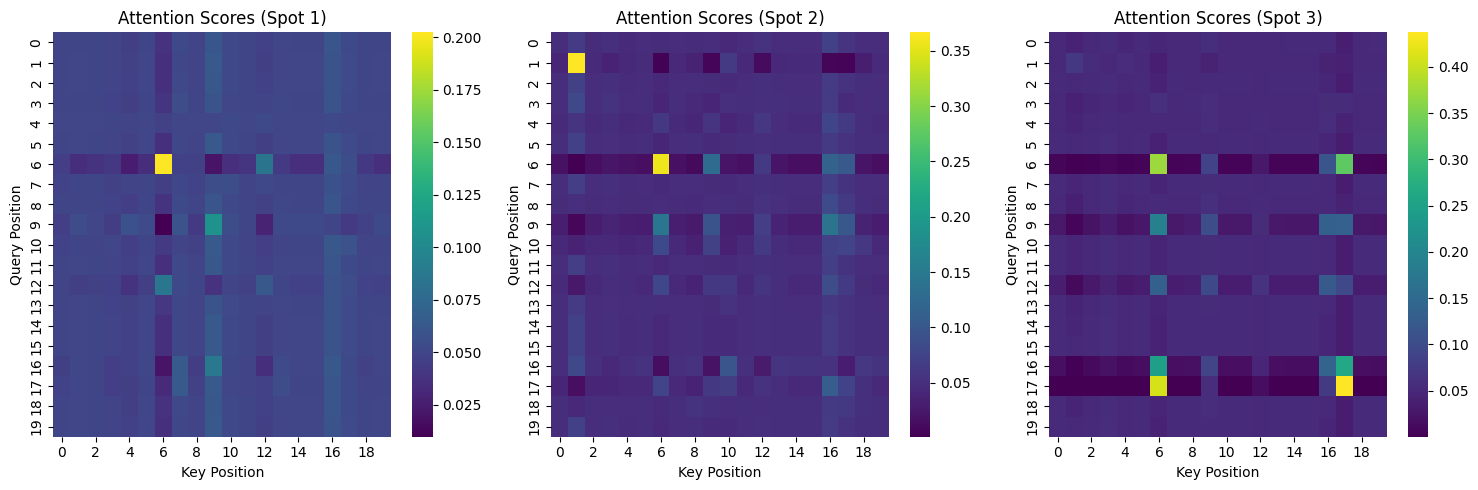

In [ ]:
# 注意力得分可视化
import seaborn as sns
def visualize_attention(attn_weights, title="Attention Scores"):
    # 假设 attn_weights 形状为 (batch_size, seq_len, seq_len)
    attn_weights = attn_weights
    fig, axes = plt.subplots(1, attn_weights.shape[0], figsize=(15, 5))
    
    for i in range(attn_weights.shape[0]):
        sns.heatmap(attn_weights[i], ax=axes[i], annot=False, cmap='viridis')
        axes[i].set_title(f"{title} (Spot {i+1})")
        axes[i].set_xlabel("Key Position")
        axes[i].set_ylabel("Query Position")
    
    plt.tight_layout()
    plt.show()

# 可视化注意力得分
# visualize_attention(attn_weights, title="Attention Scores")


Initial attention scores

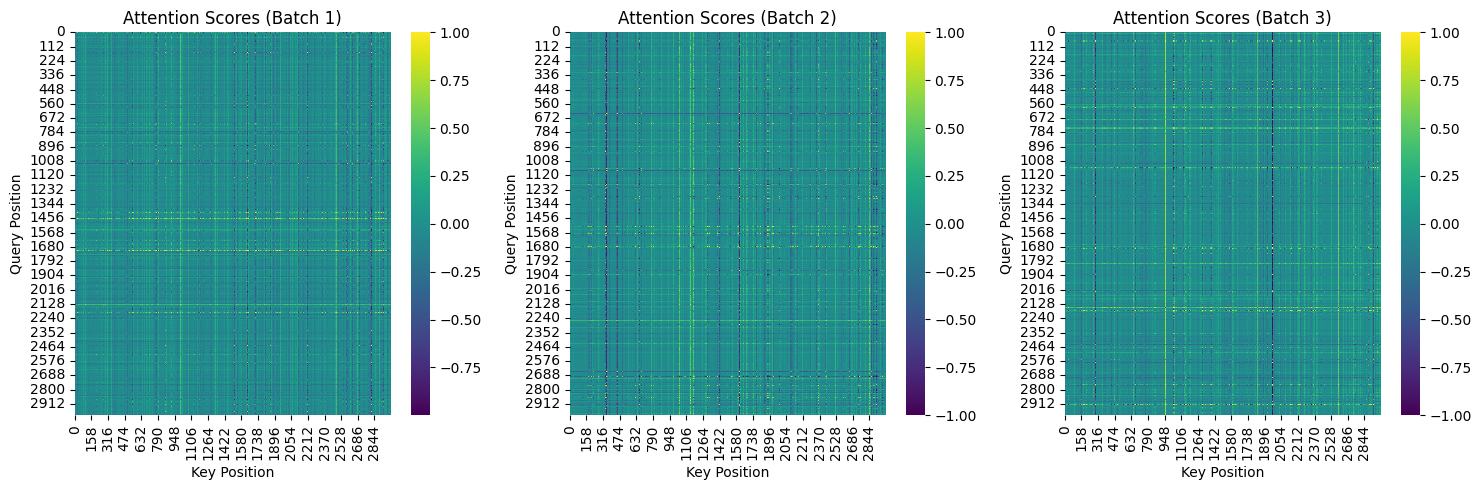

20 epoch

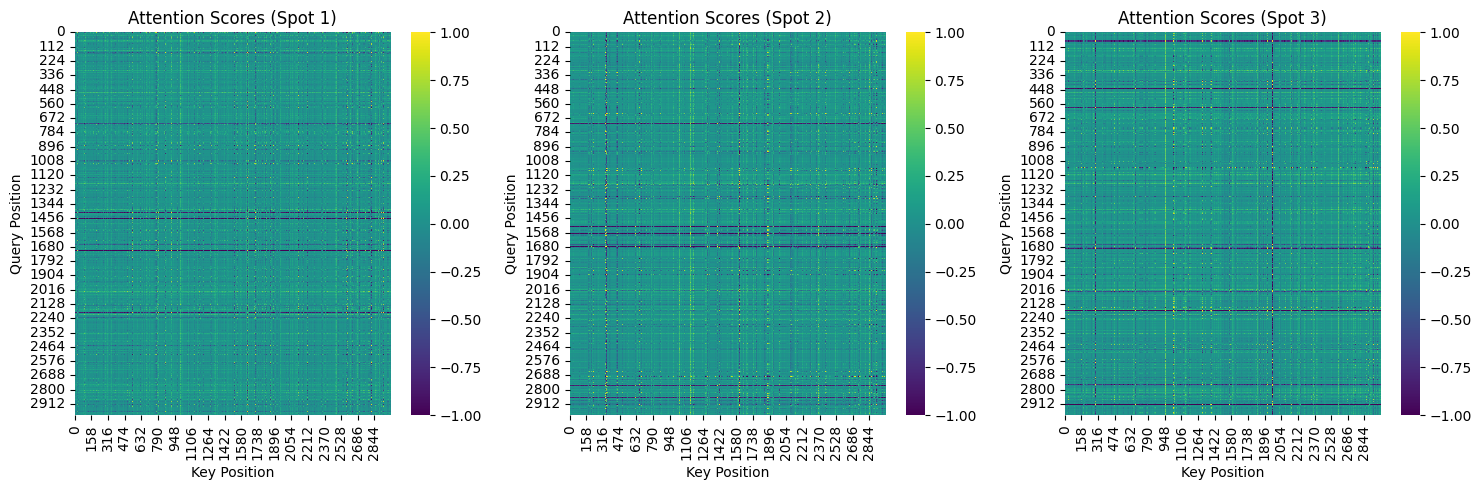

200epoch


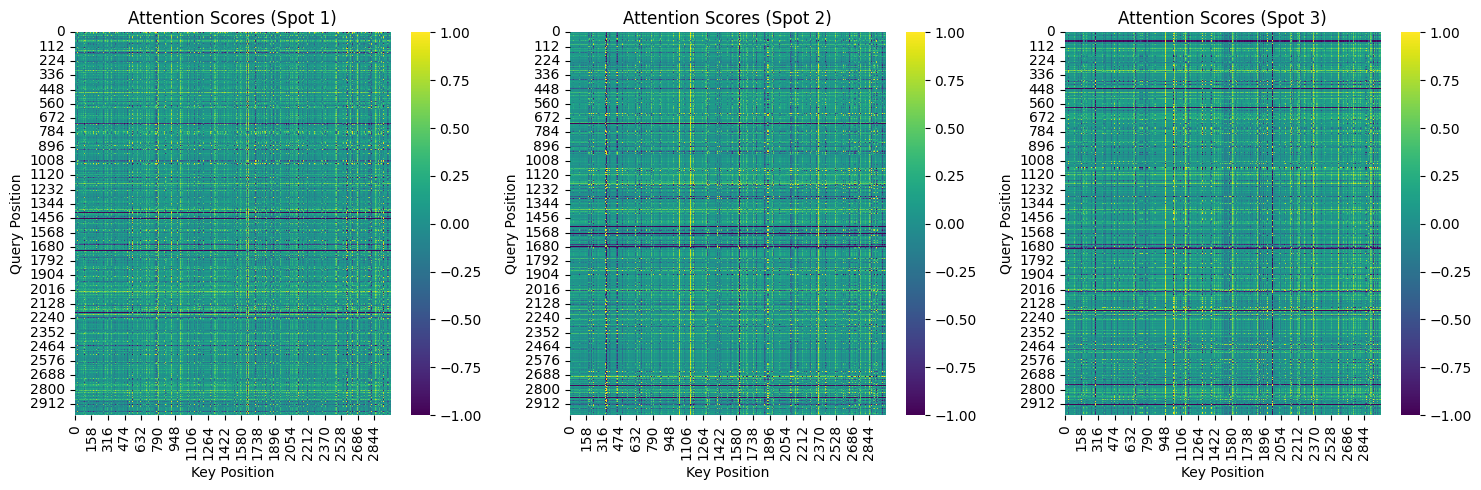

In [15]:
import pickle
with open('token_dictionary.pkl', 'rb') as file:  # 'rb' 表示以二进制读模式打开文件
    data = pickle.load(file)
len(data)

25426